# Advanced Machine Learning - programming assignment 4

*Due: Friday January 28*

**Please fill in:**
* Amy Oey (7082770)
* Sunny Hsieh (6534856)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

conda install python-graphvizThe PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

In [1]:
import numpy as np
import itertools
import graphviz # Install with: conda install python-graphviz

from AML_assignment4_util import *

The graphviz can draw graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` converts a numpy array of the form described above to a graph in graphviz format. 

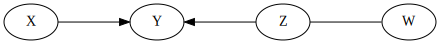

In [2]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [3]:
G1

array([[False,  True, False, False],
       [False, False, False, False],
       [False,  True, False,  True],
       [False, False,  True, False]])

In [ ]:
lijstje = itertools.combinations(range(5),2)
print(list(lijstje))

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [4]:
A = [[True, False, False, True],
     [False, True, False, True]]

Ad = A[0]
adj = [i for i in range(len(Ad)) if Ad[i] == True]
adj

[0, 3]

In [5]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k,
                    # until an independence is found.
                    # Hint: use itertools.combinations

                    # Your code here (1 point) 
                    
                    # Only adjacent combinations get through.
                    adjBool = [row[x] for row in self.G] #returns column
                    adjBool[y] = False                   #adj(X) without Y
                    
                    adj = [i for i in range(len(adjBool)) if adjBool[i] == True]
                    all_adj = itertools.combinations(adj,k) #get all combinations
                                                        
                    for S in all_adj: # replace this line by your code -Done
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print("independence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print("dependence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures
        # Something to watch out for:
        # If the data are not faithful to any graph, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!

        # Your code here (2 points)
        for x in range(self.n):
            for y in range(self.n):
                if not self.G[x,y]: #If x -> y does not exist
                    
                    # Gets the rows of x and y to see where there is an edge
                    xBool = self.G[x] 
                    yBool = self.G[y] 
                    
                    # Get lists of all nodes with whom x and y have an edge
                    adjX = [i for i in range(len(xBool)) if xBool[i] == True]
                    adjY = [i for i in range(len(yBool)) if yBool[i] == True]
                    
                    # Here we create a list with all nodes for which there is an edge between itself and both x and y
                    Zlist = list(set(adjX).intersection(set(adjY)))
                    
                    if Zlist == [] or x == y or (frozenset([x,y]) not in self.sepset and frozenset([y,x]) not in self.sepset): #Here are some situation that we do not want to follow up on in this step
                        continue
                        
                    for z in Zlist:
                        if z not in self.sepset[frozenset([x,y])] and z not in self.sepset[frozenset([y,x])]: #Here we change the edges to the v_structures when z is not in the SepSet
                            self.G[x,z] = True 
                            self.G[y,z] = True
                            self.G[z,x] = False
                            self.G[z,y] = False
        
        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules
        # Your code here (2 points)
        
        #Rule1
        def rule1():
            updated = False #For the loop at the end (can be found in every rule)
            all_directed = []
            
            for x in range(self.n):
                for y in range(self.n):
                    if self.G[x,y] == True and self.G[y,x] == False: #see where the undirected edges are and save them in the list
                        all_directed.append((x,y))
            
            for x, y in sorted(all_directed, key=lambda x:(x[1], x[0])):  #Not sure if neccessary but doing it anyways (maybe better for search? It sorts the tuples based on the y in x -> y and secondly on the x)
                for z in range(self.n):
                    if (self.G[y][z] == True and self.G[z][y] == True) and (self.G[x][z] == False and self.G[z][x] == False): # if we have x->y and x,z and y-z then we get y->z
                        self.G[y][z] = True
                        self.G[z][y] = False
                        updated = True
            
            return updated #whether the rule was used or not
        
        #Rule2
        def rule2():
            updated = False
            all_undirected = []
            
            for x in range(self.n):
                for y in range(self.n):
                    if self.G[x,y] == True and self.G[y,x] == True and (y,x) not in all_undirected: #see where the undirected edges are and save them in a list
                        all_undirected.append((x,y))
            
            for x, y in sorted(all_undirected, key=lambda x:(x[1], x[0])):
                for z in range(self.n):
                    if (self.G[x][z] == True and self.G[z][x] == False) and (self.G[y][z] == False and self.G[z][y] == True): #If x-y and x->z and z->y then we get x->y
                        self.G[x][y] = True
                        self.G[y][x] = False
                        updated = True
            
            return updated #whether the rule was used or not
        
        def rule3():
            updated = False
            all_undirected = []
            
            for x in range(self.n):
                for y in range(self.n):
                    if self.G[x,y] == True and self.G[y,x] == True and (y,x) not in all_undirected: #see where the undirected edges are and save them in a list
                        all_undirected.append((x,y))
            
            for x, y in sorted(all_undirected, key=lambda x:(x[1], x[0])):
                linked_nodes = []
                
                for z in range(self.n):
                    if (self.G[x][z] == True and self.G[z][x] == True) and (self.G[y][z] == False and self.G[z][y] == True): #We first want to find all nodes for which x-z->y holds and save z in a list
                        linked_nodes.append(z)
                
                for c1,c2 in itertools.combinations(linked_nodes,2): #Get all combinations of z and loop over them
                    if (self.G[c1][c2] == False and self.G[c2][c1] == False): # if x-c1->y and x-c2->y and x-y and c1,c2 then we get x->y
                        self.G[x][y] = True
                        self.G[y][x] = False
                        updated = True
                        
            return updated #whether the rule was used or not
        
        #Here we start to apply the rules to G in a loop
        done = False
        while not done: #Repeat till no rules apply
            updated_by_rule_1 = rule1() #do rule1
            updated_by_rule_2 = rule2() #do rule2
            updated_by_rule_3 = rule3() #do rule3
            
            if not updated_by_rule_1 and not updated_by_rule_2 and not updated_by_rule_3: #If no rules apply
                done = True #Go out of loop
                
        return

    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, the PC algorithm will recover the Markov equivalence class of the true graph.

In [6]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph `G1` we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

dependence found: X and Y given {}
independence found: X and Z given {}
independence found: X and W given {}
dependence found: Y and X given {}
dependence found: Y and Z given {}
dependence found: Y and W given {}
dependence found: Z and Y given {}
dependence found: Z and W given {}
dependence found: W and Y given {}
dependence found: W and Z given {}
dependence found: Y and X given {Z}
dependence found: Y and X given {W}
dependence found: Y and Z given {X}
dependence found: Y and Z given {W}
dependence found: Y and W given {X}
independence found: Y and W given {Z}
dependence found: Z and Y given {W}
dependence found: Z and W given {Y}
PASS


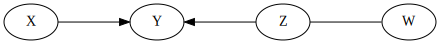

In [7]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=2)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

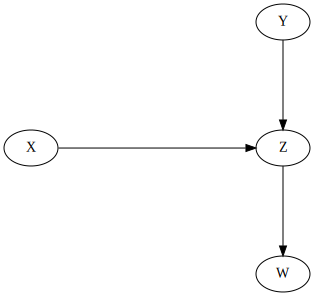

In [8]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: X and Y given {}
independence found: X and W given {Z}
independence found: Y and W given {Z}
PASS


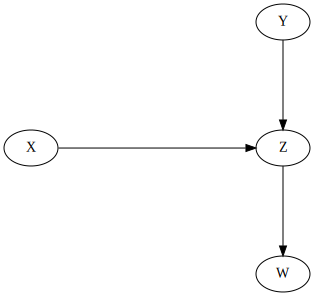

In [9]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

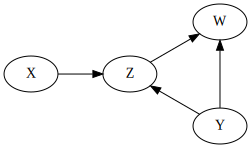

In [10]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
PASS


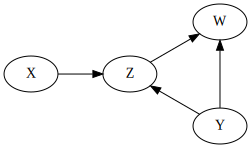

In [11]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

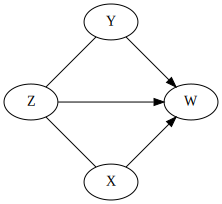

In [12]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
PASS


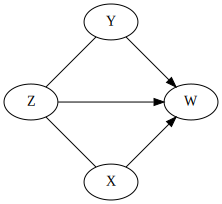

In [13]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

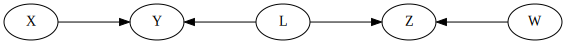

In [14]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
FAIL


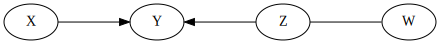

In [15]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(G) == 3 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

#It was metnioned in the online tutorial channel that this result is fine as well!

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [16]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [17]:
# Your code here (0.5 point)
all_data_experiment = all_data[all_data["experiment"] == 1]
all_data_experiment = all_data_experiment.drop(["experiment"], axis=1)
all_data_experiment

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.594569,3.144152,2.934920,3.342862,4.231204,2.810005,3.295837,6.049733,3.295837,4.005513,3.912023
1,3.826465,3.277145,3.104587,3.288402,2.897568,3.353407,3.749504,5.891644,2.593013,3.277145,4.269697
2,4.239887,3.990834,3.202746,3.005683,3.135494,3.214868,3.749504,6.023448,3.063391,3.735286,3.384390
3,4.418841,4.530447,3.499533,3.157000,2.423917,2.761907,3.081910,6.287859,3.165475,3.653252,3.499533
4,3.777348,3.394508,2.720637,2.982140,3.549617,3.437208,4.027136,5.752573,2.685123,3.575151,4.514151
...,...,...,...,...,...,...,...,...,...,...,...
848,3.955082,3.627004,3.449988,4.355426,3.104587,2.905808,3.250374,6.349139,3.462606,3.681351,2.905808
849,4.278054,3.456317,2.973487,2.802754,3.790985,3.230804,3.499533,5.796058,3.086487,3.817712,4.109233
850,4.727388,3.742420,3.005683,3.144152,4.109233,2.726545,2.748552,5.517453,3.198673,3.493473,2.723267
851,4.473922,3.517498,3.549617,4.254193,3.998201,3.449988,3.555348,5.700444,3.742420,4.537961,3.613617


For the next part, you will need to install the package [tigramite](https://github.com/jakobrunge/tigramite). Here are three different ways in which you might be able to install it, in the order in which we recommend you to try them:

1. `conda install -c egilliesix tigramite`

2. `conda install git pip`  
`pip install git+git://github.com/jakobrunge/tigramite.git`

3. If not in a conda environment, follow the README on github.

To run the PC algorithm on data, we need to perform (conditional) independence tests. Tigramite implements several such tests. The simplest of these tests is `ParCorr()`. It assumes the data come from a linear structural causal model, which they actually don't. We will use it anyway, because the alternatives (such as `CMIknn()` (Runge, 2018)) are more effort to install and orders of magnitude slower, while `ParCorr()` usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [18]:
%pip install tigramite

     |████████████████████████████████| 420 kB 30.1 MB/s 


In [19]:
from tigramite.independence_tests import ParCorr#, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print("test: {0} and {1} given {2} -> pval={3}".format(self.node_names[x], self.node_names[y],
                                                                   ", ".join([self.node_names[v] for v in S]),
                                                                   pval))
        return test_result

/usr/local/lib/python3.7/dist-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/usr/local/lib/python3.7/dist-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one connected component), or have just two connected components.

test: praf and pmek given  -> pval=6.283143797791793e-129
dependence found: praf and pmek given {}
test: praf and plcg given  -> pval=0.5373868874563719
independence found: praf and plcg given {}
test: praf and PIP2 given  -> pval=0.972791929704881
independence found: praf and PIP2 given {}
test: praf and PIP3 given  -> pval=0.3346593897889285
independence found: praf and PIP3 given {}
test: praf and perk given  -> pval=0.6217936401751427
independence found: praf and perk given {}
test: praf and pakts473 given  -> pval=0.3213233858427679
independence found: praf and pakts473 given {}
test: praf and PKA given  -> pval=0.9668029258427129
independence found: praf and PKA given {}
test: praf and PKC given  -> pval=0.20877767649396428
independence found: praf and PKC given {}
test: praf and P38 given  -> pval=0.09366579153448505
dependence found: praf and P38 given {}
test: praf and pjnk given  -> pval=0.5819563650509856
independence found: praf and pjnk given {}
test: pmek and praf given  

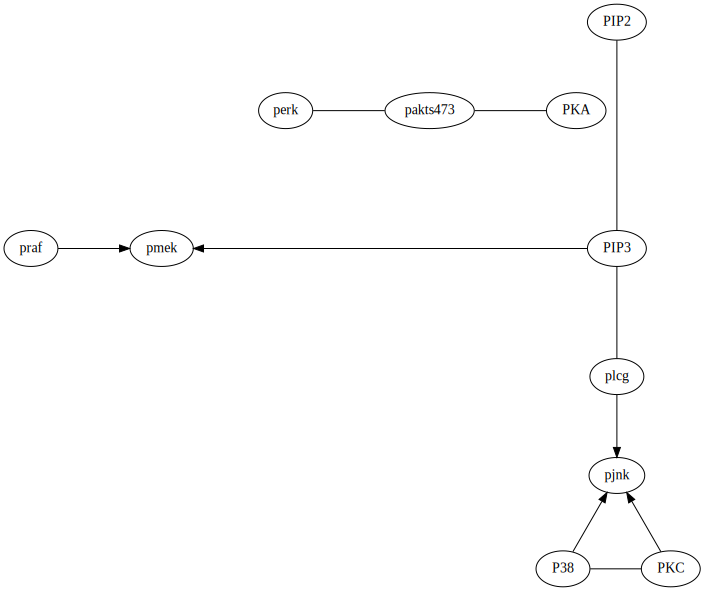

In [20]:
# Your code here (1 point)
#test with different alpha values

alpha = 0.2 #testen
oracle = IndependenceTester(all_data_experiment, ParCorr() , alpha)
A = PC_algorithm(oracle, verbose=2)
G = A.run()

graph_to_graphviz(G, oracle.node_names)

test: praf and pmek given  -> pval=6.283143797791793e-129
dependence found: praf and pmek given {}
test: praf and plcg given  -> pval=0.5373868874563719
independence found: praf and plcg given {}
test: praf and PIP2 given  -> pval=0.972791929704881
independence found: praf and PIP2 given {}
test: praf and PIP3 given  -> pval=0.3346593897889285
dependence found: praf and PIP3 given {}
test: praf and perk given  -> pval=0.6217936401751427
independence found: praf and perk given {}
test: praf and pakts473 given  -> pval=0.3213233858427679
dependence found: praf and pakts473 given {}
test: praf and PKA given  -> pval=0.9668029258427129
independence found: praf and PKA given {}
test: praf and PKC given  -> pval=0.20877767649396428
dependence found: praf and PKC given {}
test: praf and P38 given  -> pval=0.09366579153448505
dependence found: praf and P38 given {}
test: praf and pjnk given  -> pval=0.5819563650509856
independence found: praf and pjnk given {}
test: pmek and praf given  -> pva

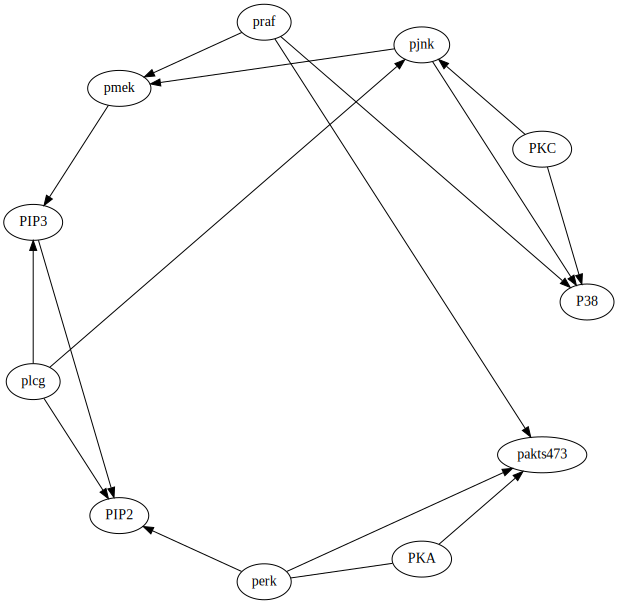

In [32]:
#we try other alphas

alpha = 0.4

oracle = IndependenceTester(all_data_experiment, ParCorr() , alpha)
A = PC_algorithm(oracle, verbose=2)
G = A.run()

graph_to_graphviz(G, oracle.node_names)

test: praf and pmek given  -> pval=6.283143797791793e-129
dependence found: praf and pmek given {}
test: praf and plcg given  -> pval=0.5373868874563719
dependence found: praf and plcg given {}
test: praf and PIP2 given  -> pval=0.972791929704881
independence found: praf and PIP2 given {}
test: praf and PIP3 given  -> pval=0.3346593897889285
dependence found: praf and PIP3 given {}
test: praf and perk given  -> pval=0.6217936401751427
independence found: praf and perk given {}
test: praf and pakts473 given  -> pval=0.3213233858427679
dependence found: praf and pakts473 given {}
test: praf and PKA given  -> pval=0.9668029258427129
independence found: praf and PKA given {}
test: praf and PKC given  -> pval=0.20877767649396428
dependence found: praf and PKC given {}
test: praf and P38 given  -> pval=0.09366579153448505
dependence found: praf and P38 given {}
test: praf and pjnk given  -> pval=0.5819563650509856
dependence found: praf and pjnk given {}
test: pmek and praf given  -> pval=6.

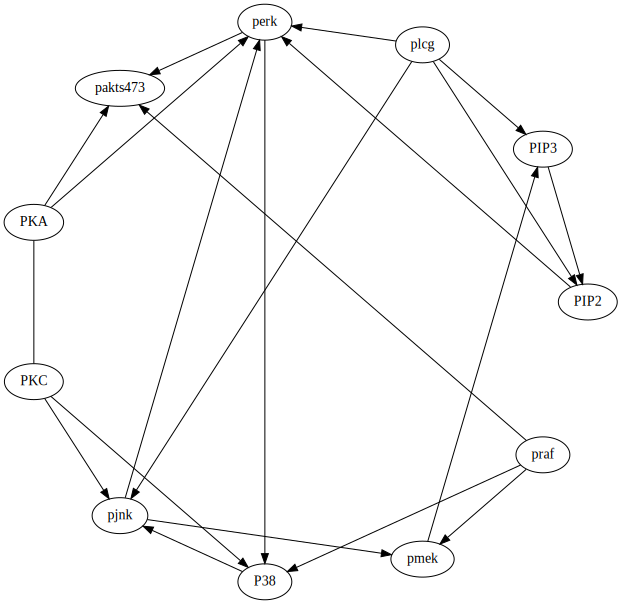

In [33]:
#Try other alpha as well
alpha = 0.6

oracle = IndependenceTester(all_data_experiment, ParCorr() , alpha)
A = PC_algorithm(oracle, verbose=2)
G = A.run()

graph_to_graphviz(G, oracle.node_names)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm to give us a rough idea of what the causal graph might look like.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [21]:
# Your code here (0.5 point)
all_data_experiment1_5 = all_data[(all_data["experiment"] == 1) | (all_data["experiment"] == 5)]
all_data_experiment1_6 = all_data[(all_data["experiment"] == 1) | (all_data["experiment"] == 6)]

In [22]:
all_data_experiment1_5

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.594569,3.144152,2.934920,3.342862,4.231204,2.810005,3.295837,6.049733,3.295837,4.005513,3.912023,1
1,3.826465,3.277145,3.104587,3.288402,2.897568,3.353407,3.749504,5.891644,2.593013,3.277145,4.269697,1
2,4.239887,3.990834,3.202746,3.005683,3.135494,3.214868,3.749504,6.023448,3.063391,3.735286,3.384390,1
3,4.418841,4.530447,3.499533,3.157000,2.423917,2.761907,3.081910,6.287859,3.165475,3.653252,3.499533,1
4,3.777348,3.394508,2.720637,2.982140,3.549617,3.437208,4.027136,5.752573,2.685123,3.575151,4.514151,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4194,4.262680,3.931826,2.636196,2.633327,3.394508,3.627004,3.998201,5.899897,3.660994,4.371976,3.804438,5
4195,4.387014,3.543854,2.397895,2.676215,3.968403,4.489759,5.105945,7.712891,2.636196,3.091042,3.770459,5
4196,4.284965,3.499533,2.590767,2.588516,3.190476,3.198673,3.627004,5.899897,3.325036,3.693867,2.595255,5
4197,4.812184,4.418841,2.397895,2.425687,3.068053,2.930660,3.716008,6.208590,3.912023,4.498698,3.983413,5


**Question (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)

**Answer** 

We see that PIP2 and PIP3 are adjacent, so we wannt to know the following:


1) Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? 

Text(0.5, 1.0, 'PIP2 of experiment 5')

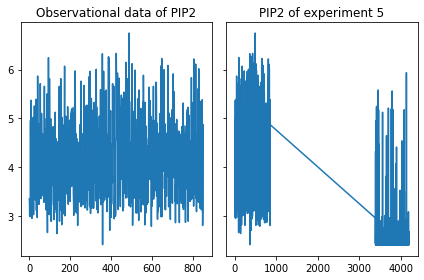

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].plot(all_data_experiment['PIP2'])
axs[0].set_title('Observational data of PIP2')
axs[1].plot(all_data_experiment1_5['PIP2'])
axs[1].set_title('PIP2 of experiment 5')


Text(0.5, 1.0, 'PIP3 of experiment 5')

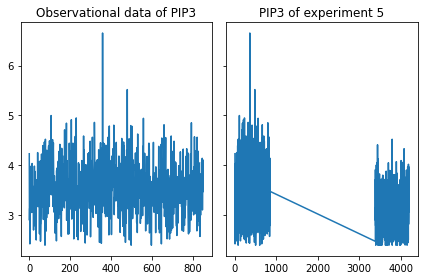

In [24]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].plot(all_data_experiment['PIP3'])
axs[0].set_title('Observational data of PIP3')
axs[1].plot(all_data_experiment1_5['PIP3'])
axs[1].set_title('PIP3 of experiment 5')


In [25]:
#fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

#axs[0][0].hist(all_data_experiment['PIP2'])
#axs[0][0].set_title('Observational data: PIP2 ')
#axs[1][0].hist(all_data_experiment1_5['PIP3'])
#axs[1][0].set_title('Observational data: PIP3')

#axs[0][1].hist(all_data_experiment['PIP2'])
#axs[0][1].set_title('Experiment 5: PIP2 ')
#axs[1][1].hist(all_data_experiment1_5['PIP3'])
#axs[1][1].set_title('Experiment 5: PIP3')


We know that experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2. If we look at the scatterplot (below) of PIP2 and PIP3, we see that they are indeed correlated: in the obeservatianol data it is around 0.38 and in experiment it is approximate 0.52. So when psitectorigenin is added, it modifies the amount of PIP2 and the neighbouring PIP3 as well which leads to a slightly higher correlation. This can also be justified when we look at the plots (above) of PIP2 and PIP3 in experiment 5 where there is a linear line in the middle. That is the case for both PIP2 and PIP3, so the amount has been modified directly as we can see in the plot.
So based on these two plots we would say that adding a substance of psitectorigenin modiefies both the amount of PIP2 and PIP3 in a direct way.

2) What does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

If we look at the plots of PIP2 and PIP3 indivudually
we noticed from the Q&A ssession that we can look at the variance of the two data

Correlation of observational data between PIP2 andd PIP3 is 0.3812865121116684
Correlation of experiment 5 data between PIP2 andd PIP3 is 0.515241261858784


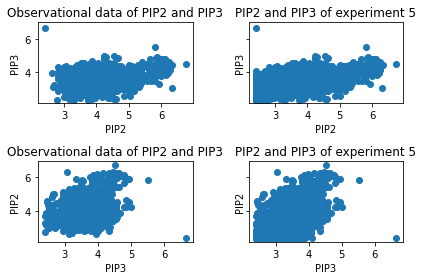

In [26]:
#all_data_experiment

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

axs[0][0].scatter(all_data_experiment['PIP2'], all_data_experiment['PIP3'])
axs[0][0].set_xlabel('PIP2')
axs[0][0].set_ylabel('PIP3')
axs[0][0].set_title('Observational data of PIP2 and PIP3')
axs[0][1].scatter(all_data_experiment1_5['PIP2'], all_data_experiment1_5['PIP3'])
axs[0][1].set_xlabel('PIP2')
axs[0][1].set_ylabel('PIP3')
axs[0][1].set_title('PIP2 and PIP3 of experiment 5')

axs[1][0].scatter(all_data_experiment['PIP3'], all_data_experiment['PIP2'])
axs[1][0].set_xlabel('PIP3')
axs[1][0].set_ylabel('PIP2')
axs[1][0].set_title('Observational data of PIP2 and PIP3')
axs[1][1].scatter(all_data_experiment1_5['PIP3'], all_data_experiment1_5['PIP2'])
axs[1][1].set_xlabel('PIP3')
axs[1][1].set_ylabel('PIP2')
axs[1][1].set_title('PIP2 and PIP3 of experiment 5')

corr_exp1 = np.corrcoef(all_data_experiment['PIP2'], all_data_experiment['PIP3'])[0][1]
corr_exp5 = np.corrcoef(all_data_experiment1_5['PIP2'], all_data_experiment1_5['PIP3'])[0][1]
print(f'Correlation of observational data between PIP2 andd PIP3 is {corr_exp1}')
print(f'Correlation of experiment 5 data between PIP2 andd PIP3 is {corr_exp5}')


In [27]:
var_pip2_obsv = np.var(all_data_experiment['PIP2'])
var_pip3_obsv = np.var(all_data_experiment['PIP3'])

var_pip2_exp5 = np.var(all_data_experiment1_5['PIP2'])
var_pip3_exp5 = np.var(all_data_experiment1_5['PIP3'])

In [28]:
print(f'The variance of PIP2 in observational data is {var_pip2_obsv}')
print(f'The variance of PIP3 in observational data is {var_pip3_obsv}')

print(f'The variance of PIP2 in experiment 5 data is {var_pip2_exp5}')
print(f'The variance of PIP3 in experiment 5 data is {var_pip3_exp5}')

The variance of PIP2 in observational data is 0.6740008436254357
The variance of PIP3 in observational data is 0.2777502590904399
The variance of PIP2 in experiment 5 data is 1.0337187274902033
The variance of PIP3 in experiment 5 data is 0.2507399618929854


So we clearly see that PIP2 has a higher variance than PIP3 in both cases. Therefore we can say that PIP2 -> PIP3.



In [29]:
all_data_experiment1_6

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.594569,3.144152,2.934920,3.342862,4.231204,2.810005,3.295837,6.049733,3.295837,4.005513,3.912023,1
1,3.826465,3.277145,3.104587,3.288402,2.897568,3.353407,3.749504,5.891644,2.593013,3.277145,4.269697,1
2,4.239887,3.990834,3.202746,3.005683,3.135494,3.214868,3.749504,6.023448,3.063391,3.735286,3.384390,1
3,4.418841,4.530447,3.499533,3.157000,2.423917,2.761907,3.081910,6.287859,3.165475,3.653252,3.499533,1
4,3.777348,3.394508,2.720637,2.982140,3.549617,3.437208,4.027136,5.752573,2.685123,3.575151,4.514151,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4993,4.216562,4.619073,3.303217,3.246491,2.806386,2.702032,3.811097,4.882802,2.426571,3.407842,2.673459,6
4994,5.874931,6.403574,3.246491,3.095578,3.387774,2.397895,4.231204,5.123964,2.466403,3.742420,2.662355,6
4995,4.859812,5.117994,3.157000,4.875197,3.918005,2.540814,4.072440,5.204007,3.100092,3.668677,3.881564,6
4996,5.459586,5.899897,3.273364,3.401197,2.955951,3.417727,5.379897,8.017308,3.430756,4.546481,4.036009,6


**Question (1.5 points)**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

**Answer** 

To make it easier, we added the graph below where we used alpha = 0.2. As we can see, variables that are adjacent to pmek are PIP3 and praf. Since we have the structure 

praf -> pmek <- PIP3

adding U0126 intevernes on the activity of pmek such that the arrows of prak to pmek and PIP3 to pmek disappear such that we have:

praf        pmek         PIP3 (without the arrows)

We look at this in more detail using graphs:



Correlation of observational data between pmek andd PIP3 is 0.06798142759528408
Correlation of experiment 5 data between pmek andd PIP3 is -0.07516274602993966


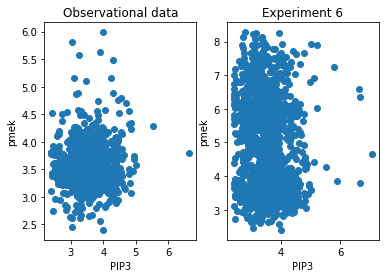

In [30]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(all_data_experiment['PIP3'], all_data_experiment['pmek'])
axs[0].set_xlabel('PIP3')
axs[0].set_ylabel('pmek')
axs[0].set_title('Observational data')
axs[1].scatter(all_data_experiment1_6['PIP3'], all_data_experiment1_6['pmek'])
axs[1].set_xlabel('PIP3')
axs[1].set_ylabel('pmek')
axs[1].set_title('Experiment 6')

corr_pip3_pmek_obs = np.corrcoef(all_data_experiment['pmek'], all_data_experiment['PIP3'])[0][1]
corr_pip3_pmek_exp = np.corrcoef(all_data_experiment1_6['pmek'], all_data_experiment1_6['PIP3'])[0][1]
print(f'Correlation of observational data between pmek andd PIP3 is {corr_pip3_pmek_obs}')
print(f'Correlation of experiment 5 data between pmek andd PIP3 is {corr_pip3_pmek_exp}')

Correlation of observational data between pmek andd praf is 0.7046101279582463
Correlation of experiment 5 data between pmek andd praf is 0.9452786738937125


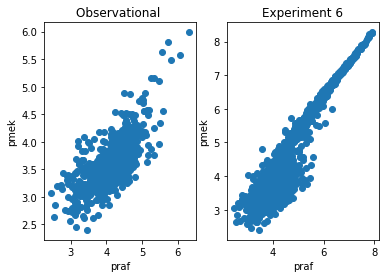

In [31]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(all_data_experiment['praf'], all_data_experiment['pmek'])
axs[0].set_xlabel('praf')
axs[0].set_ylabel('pmek')
axs[0].set_title('Observational ')
axs[1].scatter(all_data_experiment1_6['praf'], all_data_experiment1_6['pmek'])
axs[1].set_xlabel('praf')
axs[1].set_ylabel('pmek')
axs[1].set_title('Experiment 6')

corr_praf_pmerk_obs = np.corrcoef(all_data_experiment['pmek'], all_data_experiment['praf'])[0][1]
corr_praf_pmerk_exp = np.corrcoef(all_data_experiment1_6['pmek'], all_data_experiment1_6['praf'])[0][1]
print(f'Correlation of observational data between pmek andd praf is {corr_praf_pmerk_obs}')
print(f'Correlation of experiment 5 data between pmek andd praf is {corr_praf_pmerk_exp}')

###pmek <- PIP3

We would expect to see a much higher correlation in the observational data, and then a lower correlation in experiment 6 data. However the correlation in the observational data is 0.07, which would indicates that they are independent, so ofcourse after an intervention the correlation in experiment 6 data is also very low around 0: -0.08 in this case.

###praf -> pmek

Based on the graph we would expect a high correlation in the observational data and a low correlation in the experiment 6 data. We see a correlation of 0.7 in the observational data, which matches our expectation, but a high correlation as well in the experiment 6 data. which didn't match our expectation.

###Proposal

Based on these findings, we would suggest a change in the graph like this:

an arrow from pmek to praf: praf <- pmek

and no arrow between PIP3 and pmek.

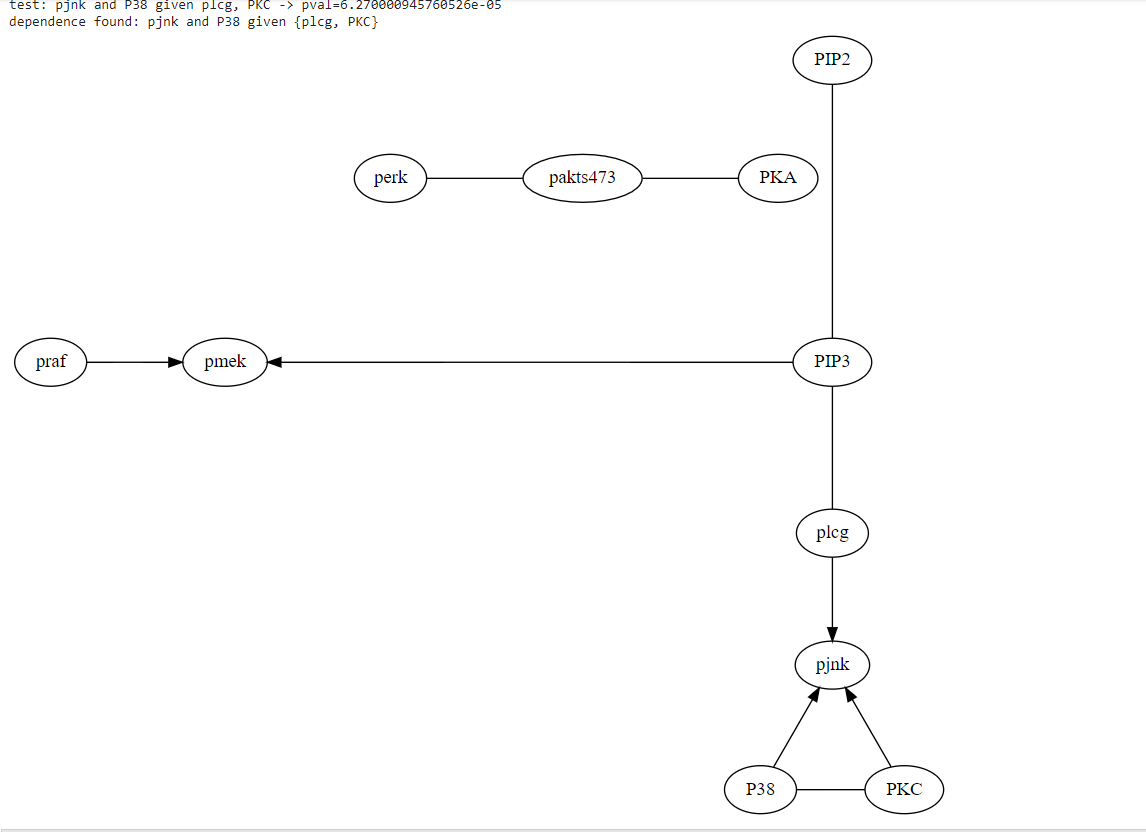

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.